In [1]:
import sys
import os
import numpy as np
import pandas as pd

import h5py

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from vis_helpers import *


In [4]:
#Load scores for the selected set of GTEx tissues (grad)

import gc

seqs = None
strands = None
chrs = None
starts = None
ends = None
genes = None

all_scores_hyp = []
all_scores = []

gtex_tissues = ['liver']

#Load score file
score_file = h5py.File('../../../examples/saved_models/gtex_CFHR2/scores_f3c0.h5', 'r')

#Get scores and onehots
scores = score_file['grads'][()][..., 0]
seqs = score_file['seqs'][()]

#Get auxiliary information
strands = score_file['strand'][()]
strands = np.array([strands[j].decode() for j in range(strands.shape[0])])

chrs = score_file['chr'][()]
chrs = np.array([chrs[j].decode() for j in range(chrs.shape[0])])

starts = np.array(score_file['start'][()])
ends = np.array(score_file['end'][()])

genes = score_file['gene'][()]
genes = np.array([genes[j].decode().split(".")[0] for j in range(genes.shape[0])])

#Append hypothetical scores
all_scores_hyp.append(scores[None, ...])

#Append input-gated scores
all_scores.append((scores * seqs)[None, ...])

#Collect garbage
gc.collect()

#Collect final scores
scores_hyp = np.concatenate(all_scores_hyp, axis=0)
scores = np.concatenate(all_scores, axis=0)

print("scores_hyp.shape = " + str(scores_hyp.shape))
print("scores.shape = " + str(scores.shape))

score_file = None

#Collect garbage
gc.collect()


scores_hyp.shape = (1, 1, 524288, 4)
scores.shape = (1, 1, 524288, 4)


0

-- Example = 0 --
 - ENSG00000080910(+)
 - chr1:196692638-197216926
 -- min_val = -1.719
 -- max_val = 3.385
 - (Gradient score profiles per tissue) - 


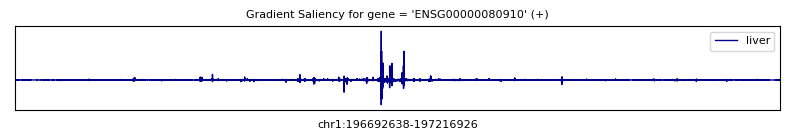

 - (Attribution at position of Max positive differential saliency) -
 - max_pos (rel) = 251085
 - max_pos (abs) = 196943723
 - chr1:196943627-196943819
 - y_min = -1.78648438
 - y_max = 3.45445312
liver


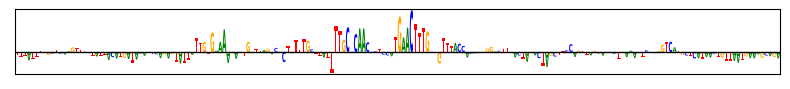

--------------------



In [7]:
#Enumerate and visualize attributions; liver example CFHR2

save_index = []

#Visualization parameters
logo_width = 192

top_n = 1

use_gaussian = True
min_padding = 65536
gaussian_sigma = 8
local_window = 1024

main_tissue_ix = 0

tissue_colors = ['darkblue']

#Loop over examples
for example_ix in range(top_n) :
    
    print("-- Example = " + str(example_ix)+ " --")
    
    print(" - " + genes[example_ix] + "(" + str(strands[example_ix]) + ")")
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]))

    #Grad analysis
    
    #Calculate min and max scores globally (for scales)
    min_val = np.min(scores[:, example_ix, ...])
    max_val = np.max(scores[:, example_ix, ...])
    
    print(" -- min_val = " + str(round(min_val, 4)))
    print(" -- max_val = " + str(round(max_val, 4)))
    
    max_abs_val = max(np.abs(min_val), np.abs(max_val))

    min_val -= 0.1 * max_abs_val
    max_val += 0.1 * max_abs_val

    print(" - (Gradient score profiles per tissue) - ")
    
    #Gradient profiles across input sequence
    f, ax = plt.subplots(len(gtex_tissues), 1, figsize=(8, len(gtex_tissues) * 1.5))
    
    if len(gtex_tissues) == 1 :
        ax = [ax]

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :

        #Get tissue scores
        score = scores[tissue_ix, example_ix, ...]

        l1 = ax[tissue_ix].plot(np.arange(seqs.shape[1]), np.sum(score, axis=-1), linewidth=1, linestyle='-', color=tissue_colors[tissue_ix], label=gtex_tissues[tissue_ix])
        
        plt.sca(ax[tissue_ix])
        
        plt.xlim(0, seqs.shape[1])
        plt.ylim(min_val, max_val)
        
        plt.legend(handles=[l1[0]], fontsize=8)
        
        plt.yticks([], [])
        plt.xticks([], [])
    
    plt.sca(ax[0])
    plt.title("Gradient Saliency for gene = '" + genes[example_ix] + "' (" + str(strands[example_ix]) + ")", fontsize=8)
    
    plt.sca(ax[len(gtex_tissues)-1])
    plt.xlabel(chrs[example_ix] + ":" + str(starts[example_ix]) + "-" + str(ends[example_ix]), fontsize=8)
    
    plt.sca(plt.gca())
    plt.tight_layout()
    
    plt.show()

    #Apply gaussian filter
    smooth_score = np.sum(scores[main_tissue_ix, example_ix, ...], axis=-1)
    if use_gaussian :
        smooth_score = gaussian_filter1d(smooth_score.astype('float32'), sigma=gaussian_sigma, truncate=2).astype('float16')
    
    #Calculate min/max positions and (differential) values
    max_pos = np.argmax(smooth_score[min_padding:-min_padding]) + min_padding

    print(" - (Attribution at position of Max positive differential saliency) -")

    print(" - max_pos (rel) = " + str(max_pos))
    print(" - max_pos (abs) = " + str(starts[example_ix] + max_pos))
    
    #Visualize contribution scores
    plot_start = max_pos - logo_width // 2
    plot_end = max_pos + logo_width // 2
    
    print(" - " + chrs[example_ix] + ":" + str(starts[example_ix] + max_pos - logo_width // 2) + "-" + str(starts[example_ix] + max_pos + logo_width // 2))

    #Logo min/max value across tissues
    min_logo_val = np.min(scores[:, example_ix, plot_start:plot_end, :])
    max_logo_val = np.max(scores[:, example_ix, plot_start:plot_end, :])

    max_abs_logo_val = max(np.abs(min_logo_val), np.abs(max_logo_val))

    min_logo_val -= 0.02 * max_abs_logo_val
    max_logo_val += 0.02 * max_abs_logo_val

    print(" - y_min = " + str(round(min_logo_val, 8)))
    print(" - y_max = " + str(round(max_logo_val, 8)))

    #Loop over tissues
    for tissue_ix in range(len(gtex_tissues)) :
        print(gtex_tissues[tissue_ix])

        #Get tissue-specific scores
        score = scores[tissue_ix, example_ix, plot_start:plot_end, :]

        #Plot scores as sequence logo
        plot_seq_scores(
            score,
            y_min=min_logo_val,
            y_max=max_logo_val,
            figsize=(8, 1),
            plot_y_ticks=False,
        )
    
    print("--------------------")
    print("")
